# Low rank tensor decomposition

The following example demonstrate feature extraction using low-rank tensor decomposition from data obtained by evaluating analytical functions.
The example is adapted from the lecture of Nathan Kutz (see Literature in README.md).

Objective of this example is to:
- Synthesize an analytical test function with some features
- Perform low-rank decomposition of the formulated data in the form of a tensor
- Reconstruct the tensor from low-rank representation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

In [2]:
#%matplotlib notebook

## Problem definition

We define a tensor of order 3 with dimensions $x,y,z$.

$x,y$ denote the spatial coordinates and $t$ the temporal dimension.

In [3]:
x = np.linspace(-5,5,101)
y = np.linspace(-6,6,121)
t = np.linspace(0,10*np.pi,315)

[X,Y,T] = np.meshgrid(x,y,t)

We now introduce two features:
- $f_1(x,y,t)$ contain a Gaussian dependent on $x$ and $y$ and also a cosine dependent on $t$
- $f_2(x,y,t)$ contain a Gaussian, hyperbolic secant (1/cosh), hyperbolic tan and a sine terms

Change the features and observe the code below.

In [4]:
f1 = np.exp(-(X*X+0.5*Y*Y))*np.cos(2*T)
f2 = ((1/np.cosh(X))*np.tanh(X)*np.exp(-0.2*Y*Y))*np.sin(T)

## Visualize

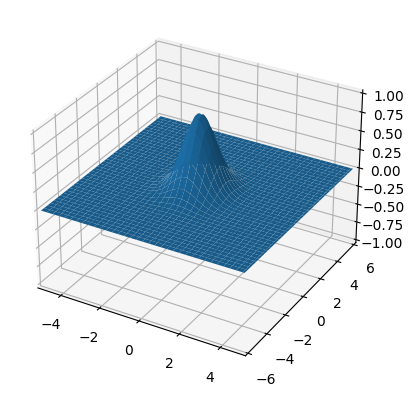

In [5]:
visualize = True
func_to_visualize = f1
if visualize:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = [ax.plot_surface(X[:,:,0], Y[:,:,0], func_to_visualize[:,:,0], antialiased=True)]
    ax.set_xlim(-5, 5)
    ax.set_ylim(-6, 6)
    ax.set_zlim(-1, 1)
    def update_plot(frame, surf, func):
        ax.collections.clear()  # Clear the previous plot
        surf[0] = ax.plot_surface(X[:,:,frame], Y[:,:,frame], func[:,:,frame], antialiased=False, cmap='gray')  # Plot new surface
        plt.title(f'frame: {frame}')
        return surf

    ani = animation.FuncAnimation(fig, update_plot, frames=len(t), fargs=(surf, func_to_visualize), interval=100)
    plt.show()

## Decomposition

Data in the form of a 3rd order tensor is prepared by combining the two functions:

In [6]:
A = f1 + f2

In [7]:
A.shape

(121, 101, 315)

/home/sreekumar/.local/lib/python3.8/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


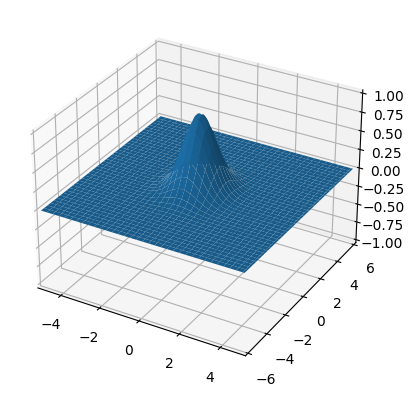

In [8]:
visualize = True

if visualize:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = [ax.plot_surface(X[:,:,0], Y[:,:,0], A[:,:,0], antialiased=True)]
    ax.set_xlim(-5, 5)
    ax.set_ylim(-6, 6)
    ax.set_zlim(-1, 1)
    def update_plot(frame, surf, func):
        ax.collections.clear()  # Clear the previous plot
        surf[0] = ax.plot_surface(X[:,:,frame], Y[:,:,frame], func[:,:,frame], antialiased=False, cmap='gray')  # Plot new surface
        plt.title(f'frame: {frame}')
        return surf

    ani = animation.FuncAnimation(fig, update_plot, frames=len(t), fargs=(surf, A), interval=100)
    plt.show()

Perform tensor decomposition using TensorLy:

In [9]:

from tensorly.decomposition import parafac
import tensorly as tl

In [10]:
r = 2   # rank two data
factors_tl = parafac(A, rank=r)

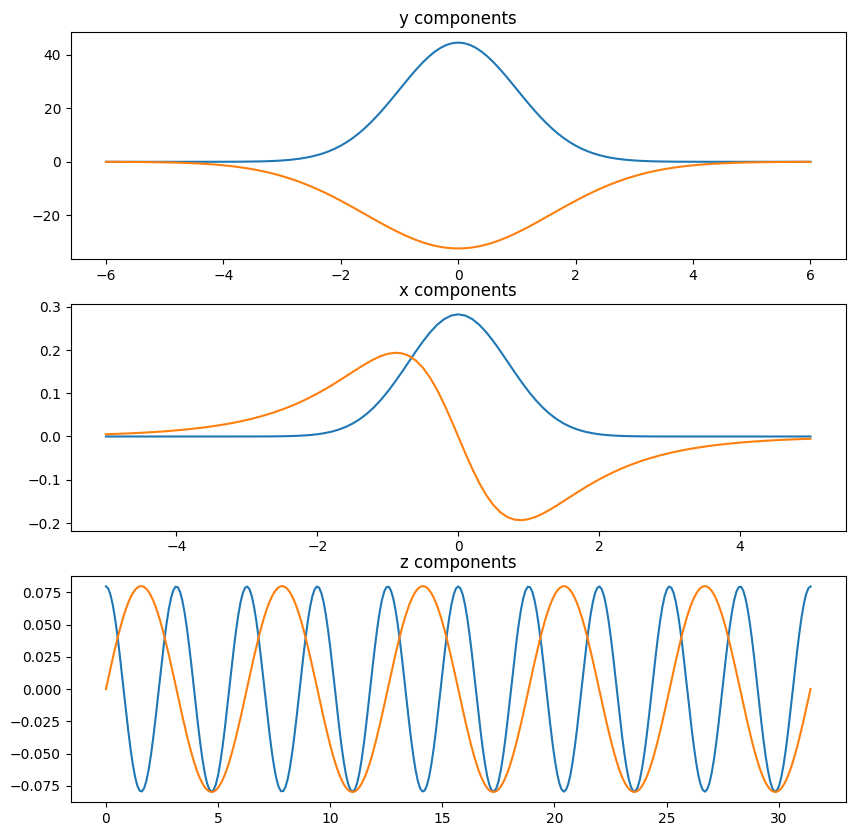

In [11]:
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.plot(y,factors_tl[1][0][:,:r])
plt.title('y components')
plt.subplot(312)
plt.plot(x,factors_tl[1][1][:,:r])
plt.title('x components')
plt.subplot(313)
plt.plot(t,factors_tl[1][2][:,:r])
plt.title('z components')
plt.show()

## Tensor reconstruction from low-rank representation

In [12]:
A_reconstructed = tl.cp_to_tensor(factors_tl)

/home/sreekumar/.local/lib/python3.8/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


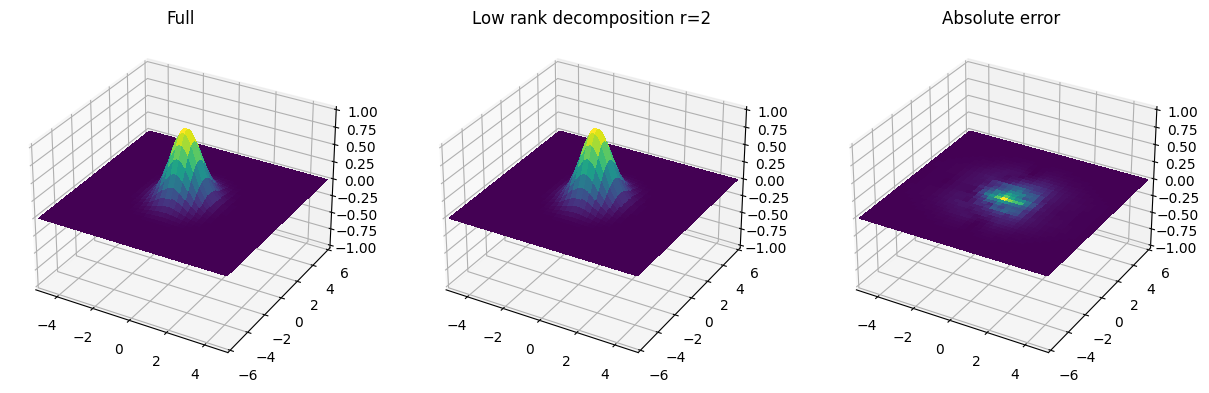

In [13]:
visualize = True

cmap = 'viridis'

if visualize:
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = [ax1.plot_surface(X[:,:,0], Y[:,:,0], A[:,:,0], antialiased=False, cmap=cmap)]
    ax1.set_xlim(-5, 5)
    ax1.set_ylim(-6, 6)
    ax1.set_zlim(-1, 1)
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = [ax2.plot_surface(X[:,:,0], Y[:,:,0], A_reconstructed[:,:,0], antialiased=False, cmap=cmap)]
    ax2.set_xlim(-5, 5)
    ax2.set_ylim(-6, 6)
    ax2.set_zlim(-1, 1)
    ax3 = fig.add_subplot(133, projection='3d')
    surf3 = [ax3.plot_surface(X[:,:,0], Y[:,:,0], np.abs(A_reconstructed[:,:,0]-A[:,:,0]), antialiased=False, cmap=cmap)]
    ax3.set_xlim(-5, 5)
    ax3.set_ylim(-6, 6)
    ax3.set_zlim(-1, 1)

    ax1.set_title('Full')
    ax2.set_title(f'Low rank decomposition r={r}')
    ax3.set_title('Absolute error')
    def update_plot(frame, surf1, surf2, surf3, func1, func2):
        ax1.collections.clear()  # Clear the previous plot
        ax2.collections.clear()  # Clear the previous plot
        ax3.collections.clear()  # Clear the previous plot
        surf1[0] = ax1.plot_surface(X[:,:,frame], Y[:,:,frame], func1[:,:,frame], antialiased=False, cmap=cmap)  # Plot new surface
        surf2[0] = ax2.plot_surface(X[:,:,frame], Y[:,:,frame], func2[:,:,frame], antialiased=False, cmap=cmap)  # Plot new surface
        surf3[0] = ax3.plot_surface(X[:,:,frame], Y[:,:,frame], np.abs(func2[:,:,frame]-func1[:,:,frame]), antialiased=False, cmap=cmap)  # Plot new surface
        return surf1, surf2, surf3

    ani = animation.FuncAnimation(fig, update_plot, frames=len(t), fargs=(surf1, surf2, surf3, A, A_reconstructed), interval=100)
    plt.show()